## **A Supervised Learning Classification Model Example Using Scikit Learn**

This is my attempt at producing a classification model in Python using the Scikit-Learn package.  I'm going to use Fantasy Premier League player data from the 2017/18 season to create a model that will attempt to predict the position of a player given their player stats. There are four possible prediction classes: Goalkeeper, Defender, Midfielder, Forward.

### **Notes on the Data**

The CSV file containing the player data has been preprocessed into a format compatible with Scikit-Learn. All the stats (feature) columns were numerical anyway so there were no categorical variables that needed dealing with.  There is no missing data in any of the columns of the dataset.

Players could be on the field accruing stats for up to 3420 minutes (38 full matches) during the season, indeed 10 players did just that. I removed all players from the dataset who played less than 180 minutes (the equivalent of 2 full matches). That still leaves lots of players who will have played far less than others and their comparative lack of stats will no doubt impact on model performance.  As this is an example rather than a model intending to have any great practical use I'll proceed while understanding that limitation is there.

The target column 'Position' will need to be processed as it contains strings (GK, DF, MF, FW). As I understand it in scikit-learn the prediction classes need to be numerical values, I'll show how to encode that column using scikit-learn LabelEncoder.

### **Importing our Dataset**

In [1]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#Import our CSV data file as a dataframe
fpl_data = pd.read_csv('https://eddiesport.github.io/projects/FPL_final.csv', \
                       header=0, index_col=0, encoding='cp1252')

print(fpl_data.head())
print(fpl_data.info())

                        Position  Goals Scored  Assists  Clean Sheets  \
Full Name                                                               
Eldin Jakupovic               GK             0        0             0   
Jeremy Pied                   DF             0        1             0   
Kyle Walker Peters            DF             0        2             1   
Beni Baningime                MF             0        0             0   
Konstantinos Mavropanos       DF             0        0             1   

                         Goals Conceded  Own Goals  Penalties Saved  \
Full Name                                                             
Eldin Jakupovic                       6          0                0   
Jeremy Pied                           3          0                0   
Kyle Walker Peters                    4          0                0   
Beni Baningime                        2          0                0   
Konstantinos Mavropanos               5          0            

We can see that the created DataFrame contains the players names as the index and 17 data columns.  None of the columns appears to have missing data (as expected given its been preprocessed). The 16 numerical columns are going to be our features while the 'Position' column will be our target. Lets encode this column now so scikit-learn will accept it. 

### **Encoding our Feature Column**

In [2]:
#Using Label Encoder
from sklearn.preprocessing import LabelEncoder

#Instantiate an example of LabelEncoder
le = LabelEncoder()
#Apply to our target column
fpl_data.Position = le.fit_transform(fpl_data.Position)

#Create a dictionary to show our newly encoded key/value pairs
#The class_names variable will also be used in our visualizations later
class_names = le.classes_
values = le.transform(le.classes_)
dictionary = dict(zip(class_names, values))
print(dictionary)

{'DF': 0, 'FW': 1, 'GK': 2, 'MF': 3}


As we can see, our target classes are now numeric, with 0 representing 'DF', 1 for 'FW', etc. 

### **Create our Feature and Target Arrays**

In [3]:
#Create feature (X) and target (y) arrays
feature_cols = ['Goals Scored', 'Assists', 'Clean Sheets', 'Goals Conceded', 'Own Goals', 'Penalties Saved', \
                'Penalties Missed', 'Yellow Cards', 'Red Cards', 'Saves', 'Bonus Points', 'Bonus Point System Score', \
                'Influence', 'Creativity', 'Threat', 'ICT Index']

X = fpl_data.loc[:, feature_cols]
print(X.shape)

y = fpl_data.Position
print(y.shape)

print(y.value_counts())

(441, 16)
(441,)
3    182
0    159
1     66
2     34
Name: Position, dtype: int64


Something to note is the class imbalance of our target variable, for example we have far more midfielders (182) than goalkeepers (34). This is something to bear in mind when looking at the results of testing our model later.

### **A Visualization of our Feature Columns**

I should have done some graphical EDA earlier to see if relationships between our feature columns existed. As I've just separated the feature columns out I'll produce a correlation matrix of all our 16 variables. Given there are quite a lot of variables I'll then create a heatmap of the result.

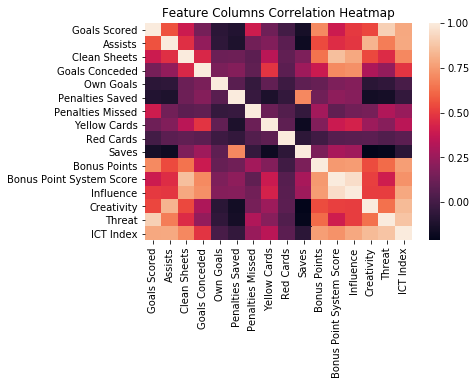

In [4]:
#Create a show a correlation matrix of the feature columns
corr_mat = X.corr()

#Visualize this matrix using Seaborns heatmap function
sns.heatmap(corr_mat)
plt.title('Feature Columns Correlation Heatmap')
plt.show()
plt.clf()

Unsurprisingly there are a range of relationships here, 'Goals Scored' and 'Threat' are highly correlated, while 'Penalities Saved' and 'Creativity' are not. There's certainly enough going on that one should hope a useful classification model could be trained using the data, so lets continue!

### **Scaling our Data**

If the various columns of data cover differing ranges (from min to max values in each column) then we should look into rescaling our data. Lets take a look.

In [5]:
#Quick look at the DataFrames column data statistical details
print(fpl_data.describe())

         Position  Goals Scored     Assists  Clean Sheets  Goals Conceded  \
count  441.000000    441.000000  441.000000    441.000000      441.000000   
mean     1.541950      2.235828    2.047619      5.773243       25.090703   
std      1.341195      3.784980    2.813926      4.104688       14.925601   
min      0.000000      0.000000    0.000000      0.000000        0.000000   
25%      0.000000      0.000000    0.000000      3.000000       13.000000   
50%      1.000000      1.000000    1.000000      5.000000       24.000000   
75%      3.000000      3.000000    3.000000      9.000000       34.000000   
max      3.000000     32.000000   18.000000     19.000000       63.000000   

        Own Goals  Penalties Saved  Penalties Missed  Yellow Cards  \
count  441.000000       441.000000        441.000000    441.000000   
mean     0.068027         0.047619          0.054422      2.612245   
std      0.301357         0.277980          0.280802      2.329989   
min      0.000000         

We can see a large variation in ranges, eg, 'Penalties Saved' ranges from 0-3, while Threat ranges from 0-2355.  This suggests we should include scale our data within the model.  I'll do this using Standardization. 

### **What Type of Classification Model To Use?**

Scikit-learn gives lots of choices, I'm going to use a K-Nearest Neighbors (k-NN) classifier here.  To be more thorough one could try many models and see which performs better given your metrics of choice.

### **Create a Pipeline Object**

I'm going to standardize my data, then apply the k-NN model.  This is two seperate steps, so I'll put them in a pipeline!

In [6]:
#Import required scikit-learn modules
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#Set up the pipeline steps
steps = [('scaler', StandardScaler()),
         ('knn', KNeighborsClassifier())]

#Create the pipeline object
pipeline = Pipeline(steps)

### **Hyperparameter Tuning**

We are going to tune the n_neighbors parameter of our k-NN classifier. To do this I'll create a range of 'n_neighbors' to try.  I'll use 1-20 here.  

In [7]:
#Define parameter grid for K neighbors search
k_range = np.arange(1, 21)
parameters = {'knn__n_neighbors': k_range}

### **Train Test Split**

Lets create our training and test sets.  Add in a random state for repeatability of results.

In [8]:
#Create training and test (hold out) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42, stratify=y)

### **Instantiate a GridSearch Object**

Lets add our pipeline and parameters to a gridsearch object. Cross validation is set to 3 subsets by default, I'll change it to 5 here. The result of this will be, for bettor or worse, our model.

In [9]:
#Instantiate GridSearch object.
fpl_model = GridSearchCV(pipeline, parameters, cv=5)

### **Train and Test our Model, show Model Metrics**

In [10]:
#Fit model to training set
fpl_model.fit(X_train, y_train)

#Predict labels of the test data
y_pred = fpl_model.predict(X_test)

#Compute and print metrics
from sklearn.metrics import classification_report, confusion_matrix

#Print accuracy, classification report and the best model parameters used
print('Accuracy: {}'.format(fpl_model.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(fpl_model.best_params_))

Accuracy: 0.7297297297297297
             precision    recall  f1-score   support

          0       0.69      0.78      0.73        40
          1       0.79      0.65      0.71        17
          2       1.00      0.88      0.93         8
          3       0.71      0.70      0.70        46

avg / total       0.74      0.73      0.73       111

Tuned Model Parameters: {'knn__n_neighbors': 3}


An accuracy score of 0.7298. Well its a lot better than guessing that everyone was a Midfielder (the most numerous class), that would have yielded an accuracy score of 0.41, so our model is definitely working. From our hyperparameter tuning we can see the optimum number of 'n_neighbors' in this case was 3.

Lets look at another model metric, the confusion matrix.  The following code that defines a function for visualizing a confusion matrix is not mine, its taken from the [scikit-learn docs](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py). The first example is not normalized, the second one is.  Normalizing is a good idea here because of the class imbalance we mentioned earlier.

In [11]:
#Function to visualize the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[31  0  0  9]
 [ 2 11  0  4]
 [ 1  0  7  0]
 [11  3  0 32]]
Normalized confusion matrix
[[ 0.775       0.          0.          0.225     ]
 [ 0.11764706  0.64705882  0.          0.23529412]
 [ 0.125       0.          0.875       0.        ]
 [ 0.23913043  0.06521739  0.          0.69565217]]


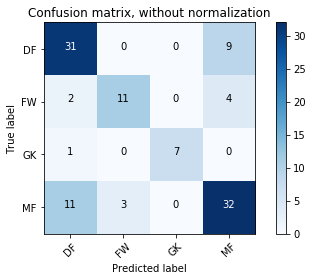

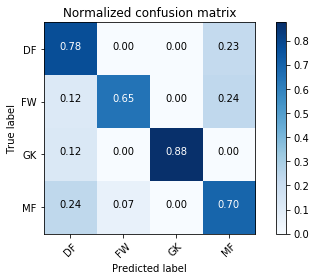

In [12]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

We can see from the normalized confusion matrix that the model was good at predicting goalkeepers on the test set, less good at predicting forwards.

If you like the created model and want to run it again in future it would be wise to save it as a file (I'm not going to do that here though).

### **Using our Model for Prediction**

I don't have an unused data set to try the model on but I will apply it here back to the original dataset and see what we get.

Accuracy: 0.8276643990929705
             precision    recall  f1-score   support

          0       0.79      0.87      0.83       159
          1       0.86      0.74      0.80        66
          2       1.00      0.94      0.97        34
          3       0.83      0.80      0.81       182

avg / total       0.83      0.83      0.83       441

Confusion matrix, without normalization
[[139   0   0  20]
 [  7  49   0  10]
 [  2   0  32   0]
 [ 29   8   0 145]]
Normalized confusion matrix
[[ 0.87421384  0.          0.          0.12578616]
 [ 0.10606061  0.74242424  0.          0.15151515]
 [ 0.05882353  0.          0.94117647  0.        ]
 [ 0.15934066  0.04395604  0.          0.7967033 ]]


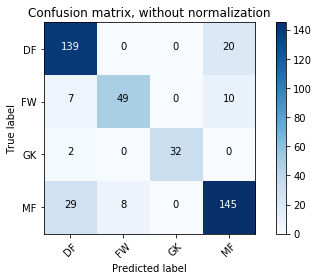

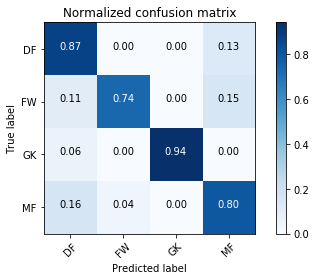

In [13]:
#Use model to predict on full dataset
model_result = fpl_model.predict(X)

#Compute and print metrics
print('Accuracy: {}'.format(fpl_model.score(X, y)))
print(classification_report(y, model_result))

#Compute confusion matrix on whole data set
cnf_matrix = confusion_matrix(y, model_result)

#Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### **Thoughts** 

What, if anything, can we ascertain from these results? We can see from the confusion matrix on the full dataset that 8 midfielders were misclassified by our model as forwards. For fantasy players these misclassifications could provide a potentially interesting insight, as midfielders who act like forwards are likely to be valuable in fantasy terms. Lets see who these 8 players actually are.

To begin I'll add the predictions back into the original dataset by adding a 'Results' column.

In [14]:
#Add model result to full dataset
fpl_data['Results'] = model_result
print(fpl_data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 441 entries, Eldin Jakupovic to Asmir Begovic
Data columns (total 18 columns):
Position                    441 non-null int64
Goals Scored                441 non-null int64
Assists                     441 non-null int64
Clean Sheets                441 non-null int64
Goals Conceded              441 non-null int64
Own Goals                   441 non-null int64
Penalties Saved             441 non-null int64
Penalties Missed            441 non-null int64
Yellow Cards                441 non-null int64
Red Cards                   441 non-null int64
Saves                       441 non-null int64
Bonus Points                441 non-null int64
Bonus Point System Score    441 non-null int64
Influence                   441 non-null float64
Creativity                  441 non-null float64
Threat                      441 non-null int64
ICT Index                   441 non-null float64
Results                     441 non-null int64
dtypes: float64(3), int6

Our new position column has been added and looks good.  I'll now do some DataFrame slicing and (just for clarity here) create a new DataFrame (fpl_wrong) that contains all the players our model misclassified.  From that new DataFrame I'll select the midfielders (class 3) who the model predicted as forwards (class 1).

In [15]:
#Create a new DataFrame of players who have been misclassified by the model
fpl_wrong = fpl_data.loc[fpl_data['Position'] != fpl_data['Results']]

#Select midfielders classified by our model as forwards
print(fpl_wrong[(fpl_wrong['Position'] == 3) & (fpl_wrong['Results'] == 1)])

                          Position  Goals Scored  Assists  Clean Sheets  \
Full Name                                                                 
Gnegneri Yaya Toure              3             0        2             0   
Adam Lallana                     3             0        0             1   
Junior Stanislas                 3             5        3             2   
Eric Maxim Choupo Moting         3             5        5             5   
James McArthur                   3             5        2             7   
Wilfried Zaha                    3             9        7            10   
Richarlison de Andrade           3             5        8             8   
Mohamed Salah                    3            32       12            15   

                          Goals Conceded  Own Goals  Penalties Saved  \
Full Name                                                              
Gnegneri Yaya Toure                    2          0                0   
Adam Lallana                     

We have our 8 players. They include Mo Salah, the Premier League top scorer in the 2017/18 season. This is promising, if any player should be misclassified its Salah, a midfielder who scores 30+ goals a season. Another player is Zaha, in this current (18/19) seasons fantasy game he is no longer listed as a midfielder but as a forward, so this misclassification is also perfectly understandable.  There is definitely scope here for checking this list between seasons to try and find potential value players for the following years game.

We'll thats our k-NN Classification model! Its not perfect, we knew given the data limitations described in the intro it couldn't be, but it still worked pretty well and could even be used to provide some insight into the fantasy Premier League game. 